In [189]:
import os
import tarfile 
import urllib 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder

In [19]:
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" 
housing_url = download_root + "datasets/housing/housing.tgz"
path_download = os.path.join('..','data','housing')

def fetch_housing_data(housing_url,path_download):
    if not os.path.isdir(path_download):
        os.makedirs(path_download)
        tgz_path = os.path.join(path_download, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=path_download)
        housing_tgz.close()

fetch_housing_data(housing_url,path_download)


In [22]:
data_path = os.path.join(path_download,'housing.csv')
housing = pd.read_csv(data_path)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [24]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [26]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

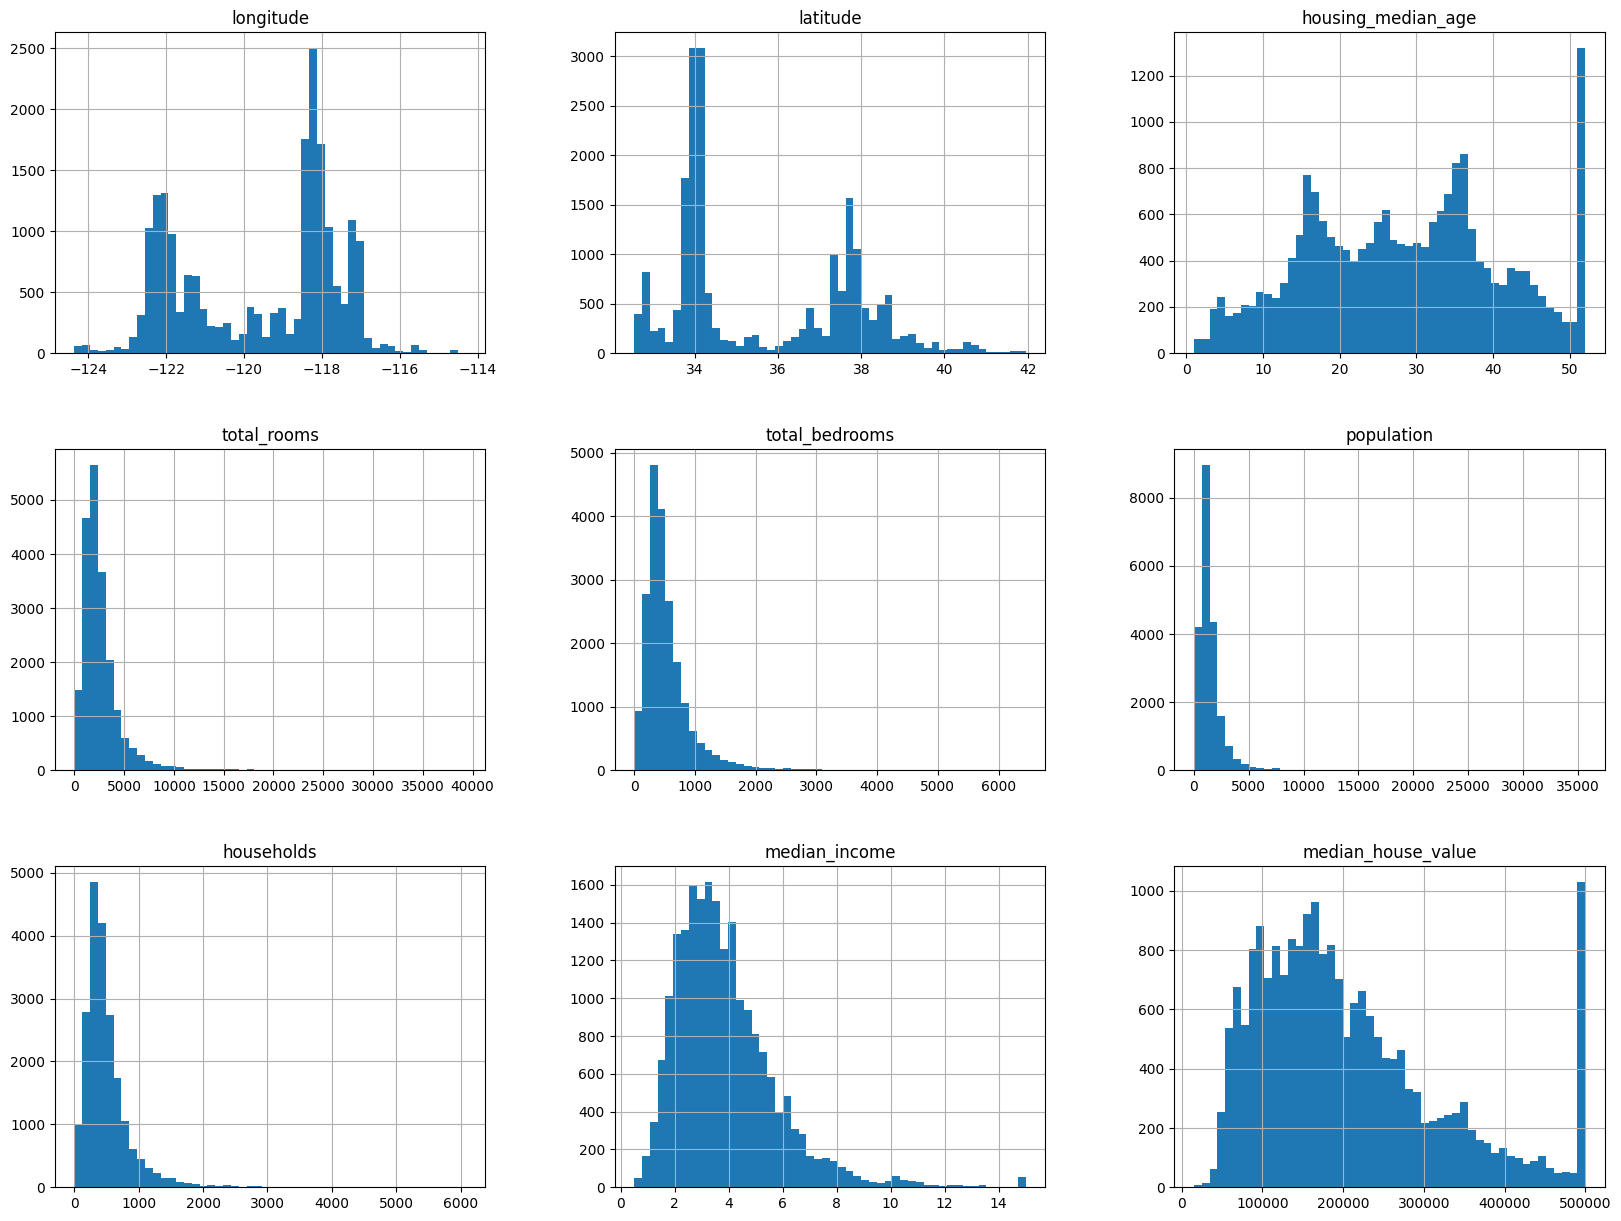

In [29]:
housing.hist(bins=50,figsize=(20,15))

# Importants point about the data

1. First, the median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers
represent roughly tens of thousands of dollars (e.g., 3 actually means about
$30,000). Working with preprocessed attributes is common in Machine Learning,
Get the Data | 53
and it is not necessarily a problem, but you should try to understand how the
data was computed.

2. A idade mediana das habitações e o valor mediano das casas também foram limitados. Este último pode ser um problema sério, já que é o seu atributo alvo (suas etiquetas). Seus algoritmos de Aprendizado de Máquina podem aprender que os preços nunca ultrapassam esse limite. Você precisa verificar com a equipe do cliente (a equipe que usará a saída do seu sistema) para ver se isso é um problema ou não. Se eles disserem que precisam de previsões precisas mesmo além de $500,000, então você tem principalmente duas opções:

        a. Coletar rótulos adequados para os distritos cujos rótulos foram limitados.

        b. Remover esses distritos do conjunto de treinamento (e também do conjunto de teste, já que seu sistema não deve ser avaliado negativamente se prever valores além de $500,000).

In [45]:
#Função split train teste

def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data)) 
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return housing.iloc[train_indices],housing.iloc[test_indices] 

train_set,test_set=split_train_test(housing,0.2)

In [46]:
len(test_set)

4128

In [50]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [51]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [52]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

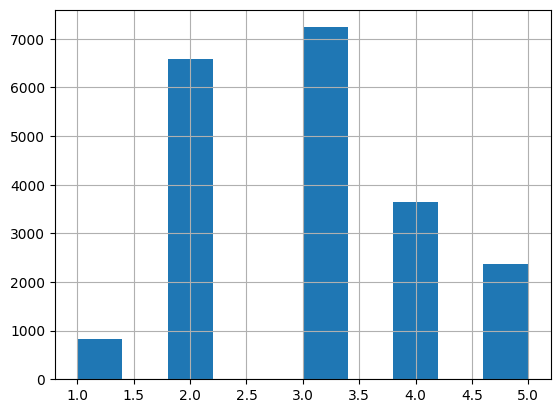

In [54]:
#Criando categorias para salários 

housing['income_cat'] =pd.cut(housing['median_income'],
                              bins=[0.,1.5,3.,4.5,6.,np.inf],
                              labels=[1,2,3,4,5])

housing['income_cat'].hist()

housing['income_cat'].value_counts() / len(housing)

In [61]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [63]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


## Explorando os dados

In [69]:
#Criando uma cópia dos dados de treino 

housing = strat_test_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

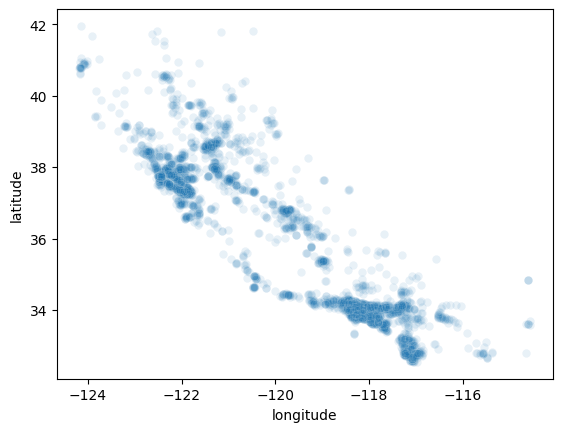

In [73]:
sns.scatterplot(data=housing,x='longitude',y='latitude',alpha=0.1)

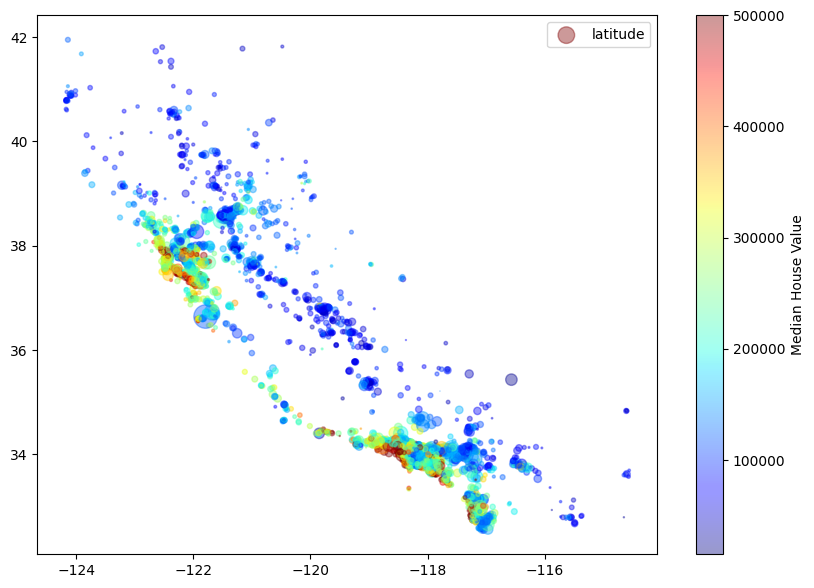

In [87]:
plt.figure(figsize=(10,7))
plt.scatter(x='longitude',y='latitude',data=housing,alpha=.4,
            s=housing['population']/100,
            c='median_house_value', 
            cmap='jet')

plt.colorbar(label = 'Median House Value')
plt.legend()


## Looking for correlations

In [93]:
corr_matrix = housing.corr(method='pearson',numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925426,-0.117560,0.028628,0.043930,0.068887,0.026334,0.002910,-0.039848
latitude,-0.925426,1.000000,0.032850,-0.024331,-0.046573,-0.084358,-0.045920,-0.099023,-0.150336
housing_median_age,-0.117560,0.032850,1.000000,-0.350487,-0.304722,-0.287470,-0.290560,-0.150288,0.071210
total_rooms,0.028628,-0.024331,-0.350487,1.000000,0.933630,0.864091,0.918768,0.191623,0.131296
total_bedrooms,0.043930,-0.046573,-0.304722,0.933630,1.000000,0.882700,0.978303,-0.000252,0.057247
population,0.068887,-0.084358,-0.287470,0.864091,0.882700,1.000000,0.916104,0.014239,-0.016164
households,0.026334,-0.045920,-0.290560,0.918768,0.978303,0.916104,1.000000,0.021517,0.070947
median_income,0.002910,-0.099023,-0.150288,0.191623,-0.000252,0.014239,0.021517,1.000000,0.691867
median_house_value,-0.039848,-0.150336,0.071210,0.131296,0.057247,-0.016164,0.070947,0.691867,1.000000


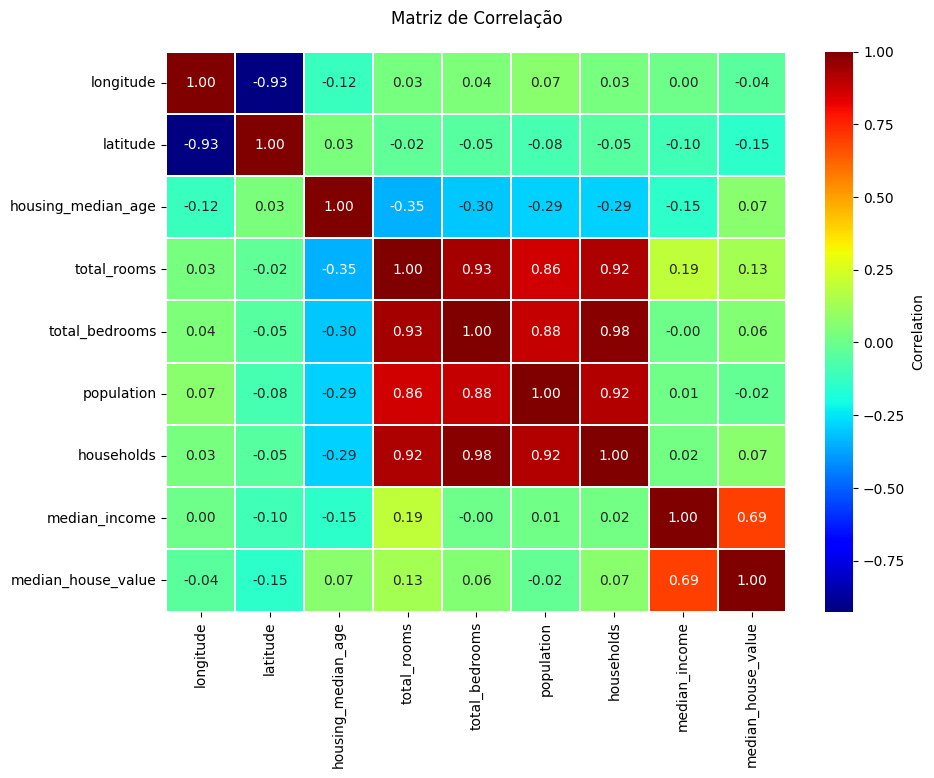

In [135]:
#Heatmap 
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            cmap='jet',
            annot=True,
            fmt='.2f',
            linecolor='white',
            linewidths=0.3,
            cbar_kws={'label':'Correlation'})
plt.title('Matriz de Correlação',pad=20)
plt.subplots_adjust(top=0.9,bottom=0.2)


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

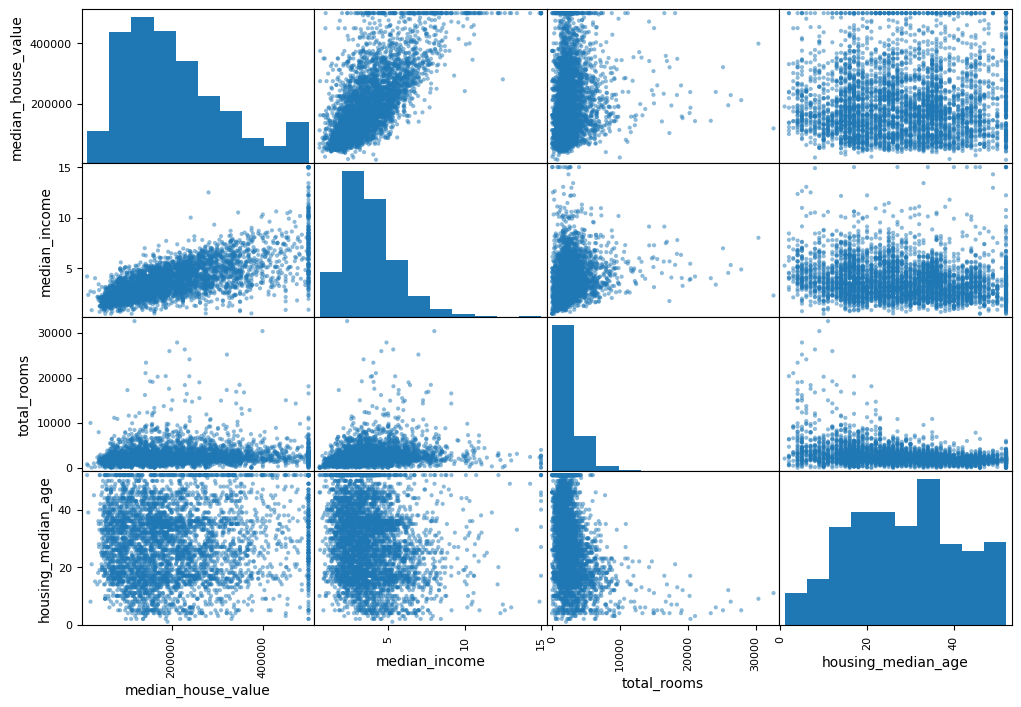

In [147]:
atributes = ['median_house_value','median_income','total_rooms','housing_median_age']
pd.plotting.scatter_matrix(housing[atributes],figsize=(12,8))

The most promissing attribute for predict the median house values is median income, let's zoom in on their correlation scatterplot

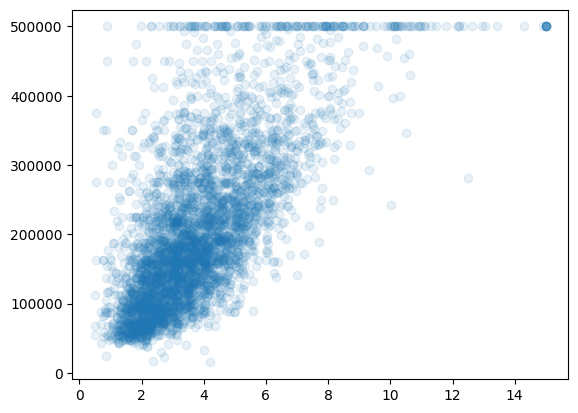

In [153]:
plt.scatter(data=housing[['median_house_value','median_income']],
            x='median_income',
            y='median_house_value',
            alpha=0.1)

## Experimenting with Attribute Combinations

In [160]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households'] 

corr_matrix = housing.corr(method='pearson',numeric_only=True) 

corr_matrix['median_house_value'].sort_values(ascending=False) 

median_house_value          1.000000
median_income               0.691867
rooms_per_household         0.192731
total_rooms                 0.131296
housing_median_age          0.071210
households                  0.070947
total_bedrooms              0.057247
population                 -0.016164
longitude                  -0.039848
population_per_household   -0.134999
latitude                   -0.150336
bedrooms_per_room          -0.240481
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

In [162]:
housing = strat_train_set.drop('median_house_value',axis=1)
housing_label = strat_train_set[['median_house_value']].copy()

Let's create imputer for to store statics of numerics variables

In [170]:
imputer = SimpleImputer(strategy='median') 
housing_num = housing.drop(housing.select_dtypes(include=('object')).columns,axis=1)
imputer.fit(housing_num) 
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [176]:
x = imputer.transform(housing_num) 
housing_tr = pd.DataFrame(data=x,columns=housing_num.columns) 
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


## Handling Text and Categorical Attributes

Let's create an enconder for the categorical variables

In [188]:
enconder = OrdinalEncoder()
housing_cat_enconder = enconder.fit_transform(housing[['ocean_proximity']])
enconder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

An ordinal encoder is useful for cases in which the variable has an ordered relation, for example, good, average, bad. But in this case, our variable doesn't have this type of relationship; therefore, for this variable, it is more interesting to create another type of encoder, such as the One-Hot Encoder. This type of encoder basically transforms each category of the variable into one column with 0 and 1, where 1 signifies that this instance belongs to this category and 0 signifies that the instance does not belong to this category.Let's make this:

In [194]:
hot_enconder = OneHotEncoder()
housing_cat_hot_enconder = hot_enconder.fit_transform(housing[['ocean_proximity']]) 
hot_enconder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers